## Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.sparse import issparse

## Loading datasets

In [32]:
toydata = pd.read_csv("toydata_tiny.csv")
X_toy = toydata[["x1", "x2"]].values
y_toy = toydata["y"].values

toydata_large = pd.read_csv("toydata_large.csv")
X_toy_large = toydata_large[["x1", "x2"]].values
y_toy_large = toydata_large["y"].values

In [118]:
# IMDB dataset
imdb = np.load("imdb.npz", allow_pickle=True)
X_imdb_train = imdb["train"].item()
X_imdb_test = imdb["test"].item()
y_imdb_train = imdb["train_labels"].reshape(-1)
y_imdb_test = imdb["test_labels"].reshape(-1)

In [122]:
# Higgs dataset
higgs = np.load("higgs.npz", allow_pickle=True)
X_higgs_train = higgs["train"]
X_higgs_test = higgs["test"]
y_higgs_train = higgs["train_labels"].reshape(-1)
y_higgs_test = higgs["test_labels"].reshape(-1)


## 1. Linear SVM with SGD Variants (29%). 

Implement a linear SVM trained with
mini-batch Stochastic Gradient Descent (SGD). Experiment with three optimizer variants: standard SGD, SGD with momentum, and Adagrad.

Train a linear SVM on each dataset (toydata.csv, toydata_large.csv, imdb.npz, higgs
.csv), selecting a suitable learning rate, regularization parameter, momentum (if applicable), and batch size.

□ Report how you selected the learning rate, batch size, and regularization parameter.
Did you use different parameters for different datasets or optimizer variants?

□ Include convergence plots for the optimizers (training loss vs. number of passes/epochs).

□ Report classification accuracy/AUC and runtime (e.g., number of epochs, total wallclock time) for each dataset and optimizer variant.

□ Compare and discuss the effects of optimizer variants and batch sizes. What trends
do you observe?

□ Briefly describe your implementation of each optimizer.

### SGD

In [174]:
# Universal function for using it with different dataset. We keep in mind that we need to use different approaches
# For two datasets we need to use CV, for Higgs we need to use AUC instead of Accuracy

def run_sgd(X_train, y_train, 
            X_test=None, y_test=None,
            dataset_name="",
            learning_rate=0.1,
            reg_strength=0.01,
            batch_size=8,
            n_epochs=50,
            n_splits=5,
            plot_loss=True):

    # Convert labels to {-1, +1} for hinge loss
    y_binary = np.where(y_train == 0, -1, 1)

    # Determine evaluation strategy
    use_cv = dataset_name.lower() in {"toydata_tiny", "toydata_large"}
    use_auc = dataset_name.lower() == "higgs"

    fold_metrics = []     # Accuracy or AUC per fold
    fold_losses = []      # List of loss curves per fold
    total_time = 0.0      # Cumulative training time

    # Safe indexing function for sparse or dense matrices
    def safe_index(X, idx):
        if issparse(X):
            if isinstance(idx, slice) or hasattr(idx, '__len__'):
                return X[idx, :]
            else:
                return X[idx]  # one row
        else:
            return X[idx]


    # Use shape[0] instead of len()
    n_samples = X_train.shape[0]

    # Set up splits
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = kf.split(np.arange(n_samples))
    else:
        # Dummy split: use all of X_train as one fold, validate on separate test set
        splits = [ (np.arange(n_samples), np.arange(n_samples)) ]

    for fold, (train_idx, val_idx) in enumerate(splits):
        # Get training and validation sets
        X_tr = safe_index(X_train, train_idx)
        y_tr = y_binary[train_idx]

        if use_cv:
            X_val = safe_index(X_train, val_idx)
            y_val = y_binary[val_idx]
        else:
            X_val = X_test
            y_val = np.where(y_test == 0, -1, 1)

        # Initialize weights
        w = np.zeros(X_tr.shape[1])

        # Store loss per epoch
        losses = []

        start = time.time()

        for epoch in range(n_epochs):
            # Shuffle training data
            indices = np.random.permutation(X_tr.shape[0])
            X_tr_shuf = safe_index(X_tr, indices)
            y_tr_shuf = y_tr[indices]

            # Iterate over mini-batches
            for i in range(0, X_tr.shape[0], batch_size):
                X_batch = safe_index(X_tr_shuf, slice(i, i + batch_size))
                y_batch = y_tr_shuf[i:i + batch_size]

                # Compute margins: y_i * (w · x_i)
                margins = y_batch * X_batch.dot(w)

                # Identify samples that violate margin (m < 1)
                mask = margins < 1

                # Compute gradient: λw - mean of misclassified gradients
                if mask.any():
                    grad = reg_strength * w - (X_batch[mask].T.dot(y_batch[mask]) / len(y_batch))
                else:
                    grad = reg_strength * w

                # Parameter update
                w -= learning_rate * grad

            # Compute loss
            margins = y_tr * X_tr.dot(w)
            hinge_loss = np.maximum(0, 1 - margins).mean()
            l2_penalty = 0.5 * reg_strength * np.sum(w ** 2)
            total_loss = hinge_loss + l2_penalty
            losses.append(total_loss)

        elapsed = time.time() - start
        total_time += elapsed

        # Evaluation on validation set 
        y_val_scores = X_val.dot(w)
        y_val_pred = np.sign(y_val_scores)

        # Compute accuracy or AUC depending on dataset
        if use_auc:
            y_true_auc = (y_val == 1).astype(int)
            metric = roc_auc_score(y_true_auc, y_val_scores)
            print(f"Fold {fold+1}: AUC = {metric:.4f}")
        else:
            metric = accuracy_score(y_val, y_val_pred)
            print(f"Fold {fold+1}: Accuracy = {metric:.4f}")

        fold_metrics.append(metric)
        fold_losses.append(losses)

        # Exit loop early if it's not CV (just one fold)
        if not use_cv:
            break

    # Final
    avg_metric = np.mean(fold_metrics)
    metric_name = "AUC" if use_auc else "Accuracy"
    print(f"\n{metric_name} = {avg_metric:.4f}")
    print(f"Total training time: {total_time:.2f}s")

    # Plot training loss curve
    if plot_loss:
        avg_loss = np.mean(fold_losses, axis=0)
        plt.plot(avg_loss)
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")
        plt.title(f"SGD on {dataset_name}")
        plt.grid(True)
        plt.show()

    return avg_metric, total_time, fold_losses


Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 0.04s


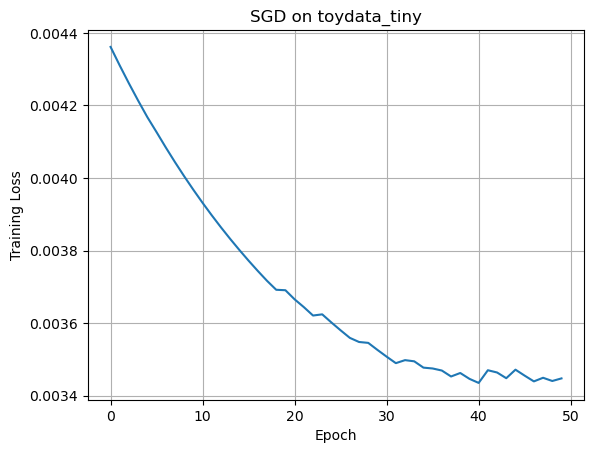

In [295]:
# toydata_tiny 
avg_metric_tiny_sgd, total_time_tiny_sgd, fold_losses_tiny_sgd = run_sgd(X_toy, y_toy, dataset_name="toydata_tiny")

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 25.29s


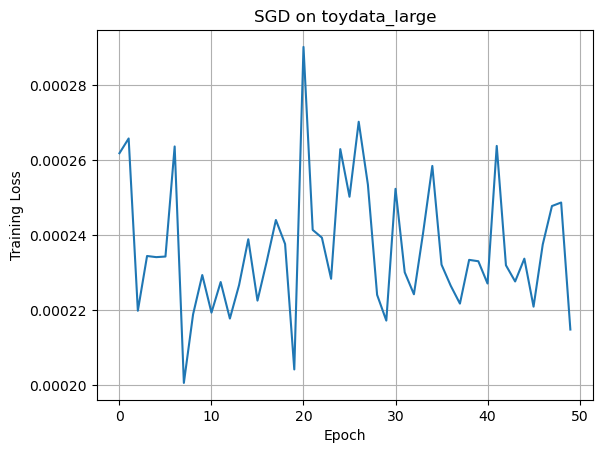

In [303]:
# toydata_large
avg_metric_large_sgd, total_time_large_sgd, fold_losses_large_sgd = run_sgd(X_toy_large, y_toy_large, dataset_name="toydata_large")

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 2.75s


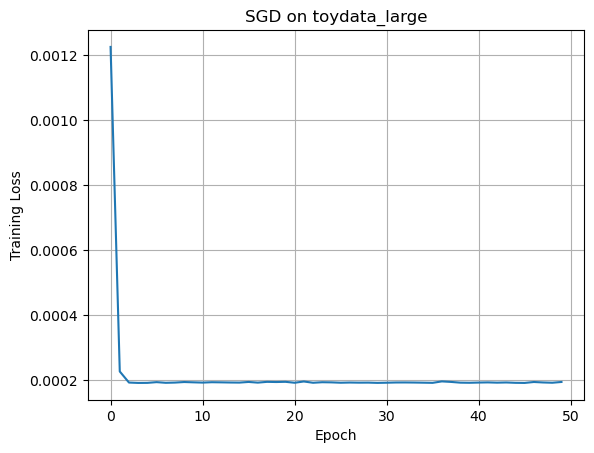

In [96]:
# toydata_large
_ = run_sgd(X_toy_large, y_toy_large, dataset_name="toydata_large", batch_size=128)

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 24.78s


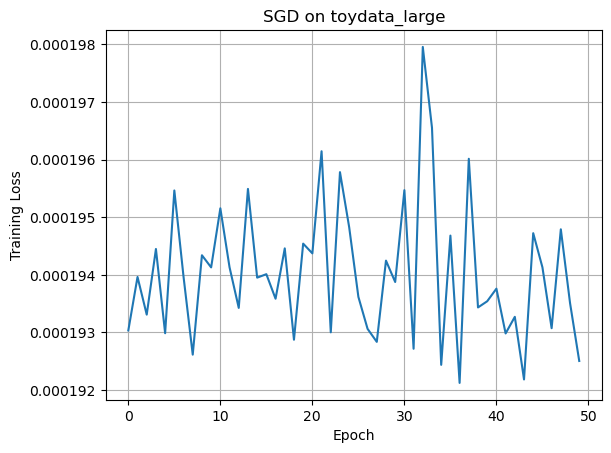

In [97]:
# toydata_large
_ = run_sgd(X_toy_large, y_toy_large, dataset_name="toydata_large", learning_rate=0.01)

Fold 1: Accuracy = 0.6810

Accuracy = 0.6810
Total training time: 2.66s


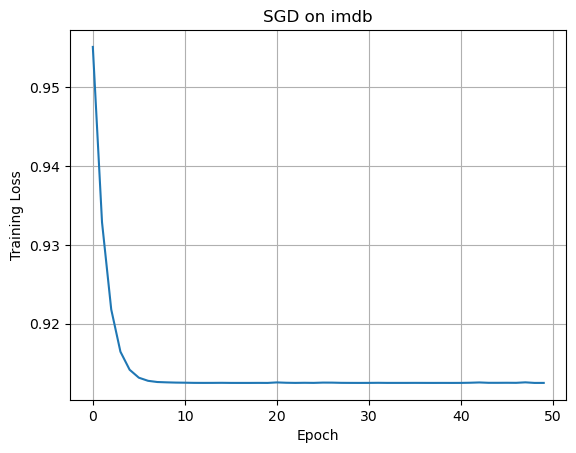

In [126]:
# imdb 
_ = run_sgd(X_imdb_train, y_imdb_train, X_test=X_imdb_test, y_test=y_imdb_test, dataset_name="imdb", batch_size=128)

Fold 1: Accuracy = 0.6396

Accuracy = 0.6396
Total training time: 18.20s


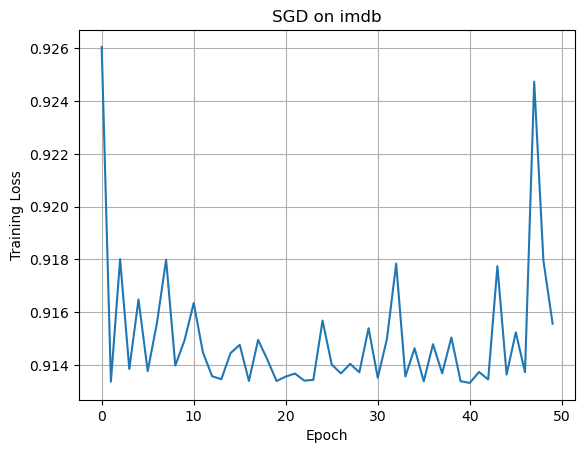

In [128]:
# imdb 
_ = run_sgd(X_imdb_train, y_imdb_train, X_test=X_imdb_test, y_test=y_imdb_test, dataset_name="imdb", batch_size=8)

Fold 1: Accuracy = 0.6814

Accuracy = 0.6814
Total training time: 5.14s


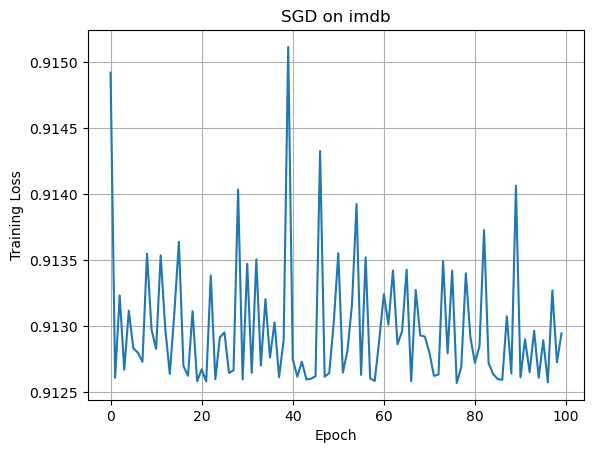

In [130]:
# imdb 
_ = run_sgd(X_imdb_train, y_imdb_train, X_test=X_imdb_test, y_test=y_imdb_test, 
            dataset_name="imdb", batch_size=128, learning_rate=0.5, n_epochs=100)


Fold 1: AUC = 0.6586

AUC = 0.6586
Total training time: 50.20s


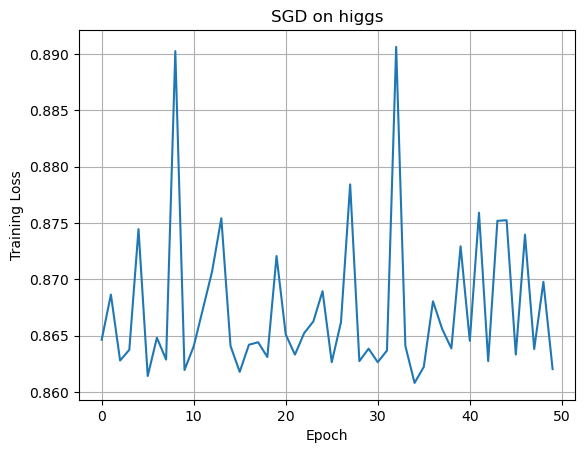

In [135]:
# higgs 
_ = run_sgd(X_higgs_train, y_higgs_train, X_test=X_higgs_test, y_test=y_higgs_test, dataset_name="higgs", batch_size=128)

Fold 1: AUC = 0.6639

AUC = 0.6639
Total training time: 99.04s


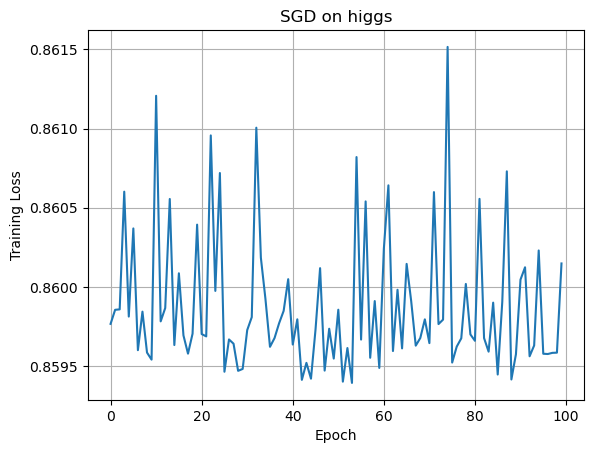

In [134]:
# higgs 
_ = run_sgd(X_higgs_train, y_higgs_train, X_test=X_higgs_test, y_test=y_higgs_test, 
            dataset_name="higgs", batch_size=128, learning_rate=0.01, n_epochs=100)

In [275]:
# Tryed different parameters, let's run through all of them

learning_rates = [0.1, 0.01]
batch_sizes = [32, 128]
reg_strengths = [0.01, 0.001]

best_score = -np.inf
best_params = None
results = []

for lr, bs, reg in product(learning_rates, batch_sizes, reg_strengths):
    print(f"Trying: lr={lr}, batch_size={bs}, reg={reg}")

    score, runtime, _ = run_sgd(
        X_imdb_train, y_imdb_train,
        X_test=X_imdb_test, y_test=y_imdb_test,
        dataset_name="imdb",
        learning_rate=lr,
        batch_size=bs,
        reg_strength=reg,
        n_epochs=50,
        plot_loss=False
    )

    results.append((score, lr, bs, reg))

    if score > best_score:
        best_score = score
        best_params = (lr, bs, reg)


Trying: lr=0.1, batch_size=32, reg=0.01
Fold 1: Accuracy = 0.6810

Accuracy = 0.6810
Total training time: 5.94s
Trying: lr=0.1, batch_size=32, reg=0.001
Fold 1: Accuracy = 0.7956

Accuracy = 0.7956
Total training time: 5.98s
Trying: lr=0.1, batch_size=128, reg=0.01
Fold 1: Accuracy = 0.6810

Accuracy = 0.6810
Total training time: 2.66s
Trying: lr=0.1, batch_size=128, reg=0.001
Fold 1: Accuracy = 0.7882

Accuracy = 0.7882
Total training time: 2.73s
Trying: lr=0.01, batch_size=32, reg=0.01
Fold 1: Accuracy = 0.6810

Accuracy = 0.6810
Total training time: 6.11s
Trying: lr=0.01, batch_size=32, reg=0.001
Fold 1: Accuracy = 0.7580

Accuracy = 0.7580
Total training time: 5.96s
Trying: lr=0.01, batch_size=128, reg=0.01
Fold 1: Accuracy = 0.6764

Accuracy = 0.6764
Total training time: 2.81s
Trying: lr=0.01, batch_size=128, reg=0.001
Fold 1: Accuracy = 0.6896

Accuracy = 0.6896
Total training time: 2.74s


In [267]:
df = pd.DataFrame(results, columns=["Accuracy", "learning_rate", "batch_size", "reg_strength"])
df_sorted = df.sort_values(by="Accuracy", ascending=False)

print(df_sorted)

   Accuracy  learning_rate  batch_size  reg_strength
1    0.7914           0.10          32         0.001
3    0.7864           0.10         128         0.001
5    0.7576           0.01          32         0.001
7    0.6904           0.01         128         0.001
4    0.6818           0.01          32         0.010
6    0.6766           0.01         128         0.010
2    0.6758           0.10         128         0.010
0    0.6738           0.10          32         0.010


In [271]:
print("Best Score:", best_score)
print("Best Parameters: lr=%.4f, batch_size=%d, reg=%.4f" % best_params)

Best Score: 0.7914
Best Parameters: lr=0.1000, batch_size=32, reg=0.0010


Fold 1: Accuracy = 0.7918

Accuracy = 0.7918
Total training time: 5.93s


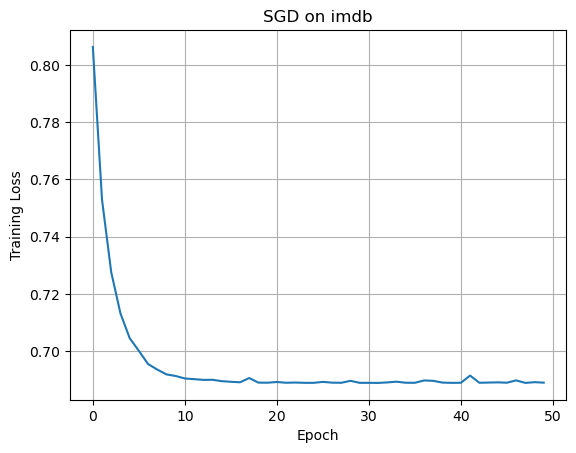

In [305]:
# imdb best
avg_metric_imdb_sgd, total_time_imdb_sgd, fold_losses_imdb_sgd = run_sgd(X_imdb_train, y_imdb_train,
                 X_test=X_imdb_test, y_test=y_imdb_test,
                 dataset_name="imdb", learning_rate = 0.1, batch_size=32, reg_strength=0.001)

In [287]:
learning_rates = [0.1, 0.01]
batch_sizes = [32, 128]
reg_strengths = [0.01, 0.001]

best_score = -np.inf
best_params = None
results = []

for lr, bs, reg in product(learning_rates, batch_sizes, reg_strengths):
    print(f"Trying: lr={lr}, batch_size={bs}, reg={reg}")

    score, runtime, _ = run_sgd(
        X_higgs_train, y_higgs_train,
        X_test=X_higgs_test, y_test=y_higgs_test,
        dataset_name="higgs",
        learning_rate=lr,
        batch_size=bs,
        reg_strength=reg,
        n_epochs=50,
        plot_loss=False
    )

    results.append((score, lr, bs, reg))

    if score > best_score:
        best_score = score
        best_params = (lr, bs, reg)

Trying: lr=0.1, batch_size=32, reg=0.01
Fold 1: AUC = 0.6416

AUC = 0.6416
Total training time: 90.19s
Trying: lr=0.1, batch_size=32, reg=0.001
Fold 1: AUC = 0.6625

AUC = 0.6625
Total training time: 90.95s
Trying: lr=0.1, batch_size=128, reg=0.01
Fold 1: AUC = 0.6587

AUC = 0.6587
Total training time: 49.81s
Trying: lr=0.1, batch_size=128, reg=0.001
Fold 1: AUC = 0.6784

AUC = 0.6784
Total training time: 50.48s
Trying: lr=0.01, batch_size=32, reg=0.01
Fold 1: AUC = 0.6631

AUC = 0.6631
Total training time: 89.23s
Trying: lr=0.01, batch_size=32, reg=0.001
Fold 1: AUC = 0.6782

AUC = 0.6782
Total training time: 89.12s
Trying: lr=0.01, batch_size=128, reg=0.01
Fold 1: AUC = 0.6633

AUC = 0.6633
Total training time: 50.00s
Trying: lr=0.01, batch_size=128, reg=0.001
Fold 1: AUC = 0.6790

AUC = 0.6790
Total training time: 50.44s


In [288]:
df = pd.DataFrame(results, columns=["AUC", "learning_rate", "batch_size", "reg_strength"])
df_sorted = df.sort_values(by="AUC", ascending=False)

print(df_sorted)

        AUC  learning_rate  batch_size  reg_strength
7  0.678964           0.01         128         0.001
3  0.678359           0.10         128         0.001
5  0.678163           0.01          32         0.001
6  0.663320           0.01         128         0.010
4  0.663132           0.01          32         0.010
1  0.662536           0.10          32         0.001
2  0.658729           0.10         128         0.010
0  0.641580           0.10          32         0.010


In [289]:
print("Best Score:", best_score)
print("Best Parameters: lr=%.4f, batch_size=%d, reg=%.4f" % best_params)

Best Score: 0.6789643018824343
Best Parameters: lr=0.0100, batch_size=128, reg=0.0010


Fold 1: AUC = 0.6781

AUC = 0.6781
Total training time: 51.09s


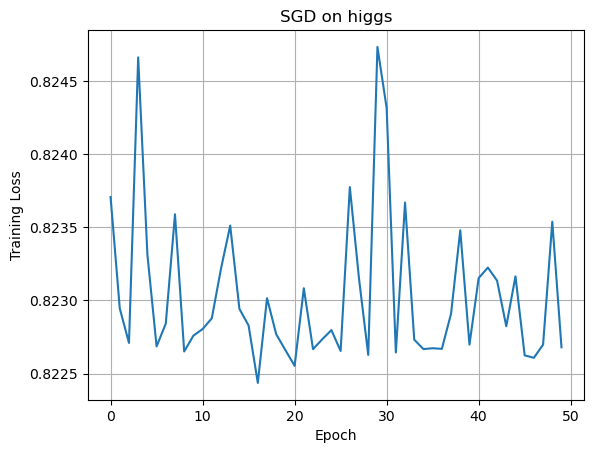

In [307]:
# higgs best
avg_metric_higgs_sgd, total_time_higgs_sgd, fold_losses_higgs_sgd = run_sgd(X_higgs_train, y_higgs_train,
                 X_test=X_higgs_test, y_test=y_higgs_test,
                 dataset_name="higgs", learning_rate = 0.01, batch_size=128, reg_strength=0.001)

### SGD with momentum

In [180]:
def run_sgd_momentum(X_train, y_train, 
                     X_test=None, y_test=None,
                     dataset_name="",
                     learning_rate=0.1,
                     reg_strength=0.01,
                     batch_size=8,
                     n_epochs=50,
                     n_splits=5,
                     momentum=0.9,
                     plot_loss=True):

    # Convert labels to {-1, +1} for hinge loss
    y_binary = np.where(y_train == 0, -1, 1)

    # Determine evaluation strategy
    use_cv = dataset_name.lower() in {"toydata_tiny", "toydata_large"}
    use_auc = dataset_name.lower() == "higgs"

    fold_metrics = []     # Accuracy or AUC per fold
    fold_losses = []      # List of loss curves per fold
    total_time = 0.0      # Cumulative training time

    # Safe indexing function for sparse or dense matrices
    def safe_index(X, idx):
        if issparse(X):
            if isinstance(idx, slice) or hasattr(idx, '__len__'):
                return X[idx, :]
            else:
                return X[idx]
        else:
            return X[idx]

    # Use shape[0] instead of len()
    n_samples = X_train.shape[0]

    # Set up splits
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = kf.split(np.arange(n_samples))
    else:
        splits = [ (np.arange(n_samples), np.arange(n_samples)) ]

    for fold, (train_idx, val_idx) in enumerate(splits):
        # Get training and validation sets
        X_tr = safe_index(X_train, train_idx)
        y_tr = y_binary[train_idx]

        if use_cv:
            X_val = safe_index(X_train, val_idx)
            y_val = y_binary[val_idx]
        else:
            X_val = X_test
            y_val = np.where(y_test == 0, -1, 1)

        # Initialize weights and velocity
        w = np.zeros(X_tr.shape[1])
        v = np.zeros_like(w)

        losses = []
        start = time.time()

        for epoch in range(n_epochs):
            # Shuffle training data
            indices = np.random.permutation(X_tr.shape[0])
            X_tr_shuf = safe_index(X_tr, indices)
            y_tr_shuf = y_tr[indices]

            for i in range(0, X_tr.shape[0], batch_size):
                X_batch = safe_index(X_tr_shuf, slice(i, i + batch_size))
                y_batch = y_tr_shuf[i:i + batch_size]

                margins = y_batch * X_batch.dot(w)
                mask = margins < 1

                if mask.any():
                    grad = reg_strength * w - (X_batch[mask].T.dot(y_batch[mask]) / len(y_batch))
                else:
                    grad = reg_strength * w

                # Momentum update
                v = momentum * v - learning_rate * grad
                w += v

            margins = y_tr * X_tr.dot(w)
            hinge_loss = np.maximum(0, 1 - margins).mean()
            l2_penalty = 0.5 * reg_strength * np.sum(w ** 2)
            total_loss = hinge_loss + l2_penalty
            losses.append(total_loss)

        elapsed = time.time() - start
        total_time += elapsed

        # Evaluation on validation set
        y_val_scores = X_val.dot(w)
        y_val_pred = np.sign(y_val_scores)

        if use_auc:
            y_true_auc = (y_val == 1).astype(int)
            metric = roc_auc_score(y_true_auc, y_val_scores)
            print(f"Fold {fold+1}: AUC = {metric:.4f}")
        else:
            metric = accuracy_score(y_val, y_val_pred)
            print(f"Fold {fold+1}: Accuracy = {metric:.4f}")

        fold_metrics.append(metric)
        fold_losses.append(losses)

        if not use_cv:
            break

    avg_metric = np.mean(fold_metrics)
    metric_name = "AUC" if use_auc else "Accuracy"
    print(f"\n{metric_name} = {avg_metric:.4f}")
    print(f"Total training time: {total_time:.2f}s")

    if plot_loss:
        avg_loss = np.mean(fold_losses, axis=0)
        plt.plot(avg_loss)
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")
        plt.title(f"SGD with Momentum on {dataset_name}")
        plt.grid(True)
        plt.show()

    return avg_metric, total_time, fold_losses


Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 0.05s


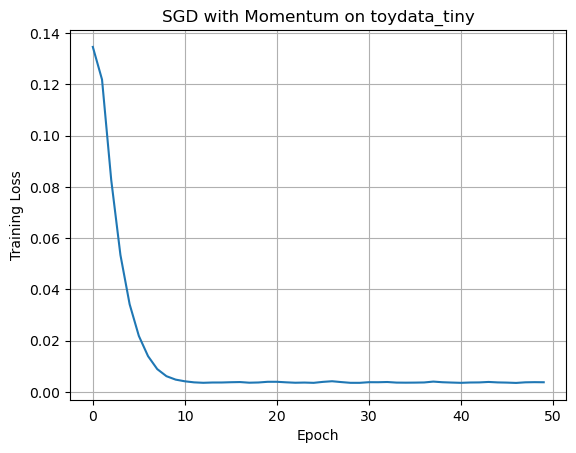

In [309]:
# toydata_tiny
avg_metric_tiny_momentum, total_time_tiny_momentum, fold_losses_tiny_momentum = run_sgd_momentum(X_toy, y_toy, dataset_name="toydata_tiny")

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 0.05s


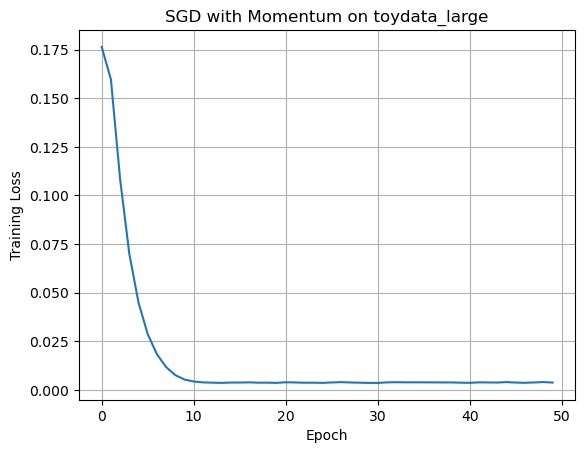

In [311]:
# toydata_large
avg_metric_large_momentum, total_time_large_momentum, fold_losses_large_momentum = run_sgd_momentum(X_toy, y_toy, dataset_name="toydata_large")

In [218]:
from itertools import product

learning_rates = [0.1, 0.01]
batch_sizes = [32, 128]
reg_strengths = [0.01, 0.001]
momentums = [0.8, 0.9] 

best_score = -np.inf
best_params = None
results = []

for lr, bs, reg, mom in product(learning_rates, batch_sizes, reg_strengths, momentums):
    print(f"Trying: lr={lr}, batch_size={bs}, reg={reg}, momentum={mom}")

    score, runtime, _ = run_sgd_momentum(
        X_imdb_train, y_imdb_train,
        X_test=X_imdb_test, y_test=y_imdb_test,
        dataset_name="imdb",
        learning_rate=lr,
        batch_size=bs,
        reg_strength=reg,
        momentum=mom,
        n_epochs=50,
        plot_loss=False
    )

    results.append((score, lr, bs, reg, mom))

    if score > best_score:
        best_score = score
        best_params = (lr, bs, reg, mom)


Trying: lr=0.1, batch_size=32, reg=0.01, momentum=0.8
Fold 1: Accuracy = 0.6438

Accuracy = 0.6438
Total training time: 6.36s
Trying: lr=0.1, batch_size=32, reg=0.01, momentum=0.9
Fold 1: Accuracy = 0.6090

Accuracy = 0.6090
Total training time: 6.35s
Trying: lr=0.1, batch_size=32, reg=0.001, momentum=0.8
Fold 1: Accuracy = 0.7826

Accuracy = 0.7826
Total training time: 6.45s
Trying: lr=0.1, batch_size=32, reg=0.001, momentum=0.9
Fold 1: Accuracy = 0.7896

Accuracy = 0.7896
Total training time: 6.51s
Trying: lr=0.1, batch_size=128, reg=0.01, momentum=0.8
Fold 1: Accuracy = 0.6778

Accuracy = 0.6778
Total training time: 2.88s
Trying: lr=0.1, batch_size=128, reg=0.01, momentum=0.9
Fold 1: Accuracy = 0.6854

Accuracy = 0.6854
Total training time: 2.84s
Trying: lr=0.1, batch_size=128, reg=0.001, momentum=0.8
Fold 1: Accuracy = 0.7944

Accuracy = 0.7944
Total training time: 2.79s
Trying: lr=0.1, batch_size=128, reg=0.001, momentum=0.9
Fold 1: Accuracy = 0.7864

Accuracy = 0.7864
Total train

In [226]:
df = pd.DataFrame(results, columns=["Accuracy", "learning_rate", "batch_size", "reg_strength", "momentum"])
df_sorted = df.sort_values(by="Accuracy", ascending=False)

print(df_sorted)

    Accuracy  learning_rate  batch_size  reg_strength  momentum
6     0.7944           0.10         128         0.001       0.8
10    0.7940           0.01          32         0.001       0.8
11    0.7936           0.01          32         0.001       0.9
3     0.7896           0.10          32         0.001       0.9
15    0.7874           0.01         128         0.001       0.9
7     0.7864           0.10         128         0.001       0.9
2     0.7826           0.10          32         0.001       0.8
14    0.7668           0.01         128         0.001       0.8
5     0.6854           0.10         128         0.010       0.9
13    0.6824           0.01         128         0.010       0.9
12    0.6822           0.01         128         0.010       0.8
9     0.6794           0.01          32         0.010       0.9
8     0.6782           0.01          32         0.010       0.8
4     0.6778           0.10         128         0.010       0.8
0     0.6438           0.10          32 

In [228]:
print("Best Score:", best_score)
print("Best Parameters: lr=%.4f, batch_size=%d, reg=%.4f, momentum=%.2f" % best_params)

Best Score: 0.7944
Best Parameters: lr=0.1000, batch_size=128, reg=0.0010, momentum=0.80


Fold 1: Accuracy = 0.7918

Accuracy = 0.7918
Total training time: 2.81s


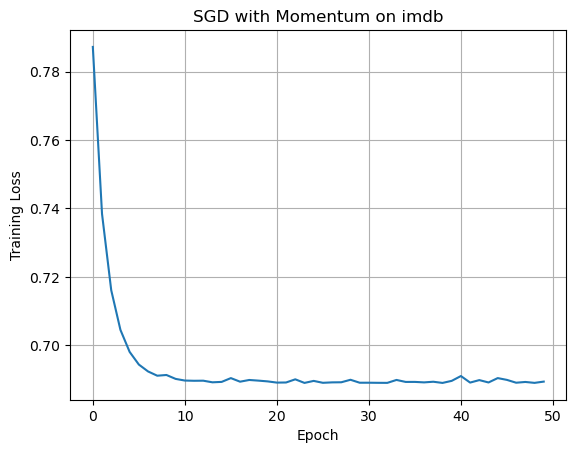

In [313]:
# imdb best
avg_metric_imdb_momentum, total_time_imdb_momentum, fold_losses_imdb_momentum = run_sgd_momentum(X_imdb_train, y_imdb_train,
                 X_test=X_imdb_test, y_test=y_imdb_test,
                 dataset_name="imdb", learning_rate = 0.1, batch_size=128, reg_strength=0.001, momentum=0.8)

In [230]:
from itertools import product

learning_rates = [0.1, 0.01]
batch_sizes = [32, 128]
reg_strengths = [0.01, 0.001]
momentums = [0.8, 0.9] 

best_score = -np.inf
best_params = None
results = []

for lr, bs, reg, mom in product(learning_rates, batch_sizes, reg_strengths, momentums):
    print(f"Trying: lr={lr}, batch_size={bs}, reg={reg}, momentum={mom}")

    score, runtime, _ = run_sgd_momentum(
        X_higgs_train, y_higgs_train,
        X_test=X_higgs_test, y_test=y_higgs_test,
        dataset_name="higgs",
        learning_rate=lr,
        batch_size=bs,
        reg_strength=reg,
        momentum=mom,
        n_epochs=50,
        plot_loss=False
    )

    results.append((score, lr, bs, reg, mom))

    if score > best_score:
        best_score = score
        best_params = (lr, bs, reg, mom)

Trying: lr=0.1, batch_size=32, reg=0.01, momentum=0.8
Fold 1: AUC = 0.6238

AUC = 0.6238
Total training time: 96.25s
Trying: lr=0.1, batch_size=32, reg=0.01, momentum=0.9
Fold 1: AUC = 0.5986

AUC = 0.5986
Total training time: 95.82s
Trying: lr=0.1, batch_size=32, reg=0.001, momentum=0.8
Fold 1: AUC = 0.6507

AUC = 0.6507
Total training time: 95.34s
Trying: lr=0.1, batch_size=32, reg=0.001, momentum=0.9
Fold 1: AUC = 0.6268

AUC = 0.6268
Total training time: 95.47s
Trying: lr=0.1, batch_size=128, reg=0.01, momentum=0.8
Fold 1: AUC = 0.6490

AUC = 0.6490
Total training time: 50.98s
Trying: lr=0.1, batch_size=128, reg=0.01, momentum=0.9
Fold 1: AUC = 0.6260

AUC = 0.6260
Total training time: 51.03s
Trying: lr=0.1, batch_size=128, reg=0.001, momentum=0.8
Fold 1: AUC = 0.6623

AUC = 0.6623
Total training time: 51.16s
Trying: lr=0.1, batch_size=128, reg=0.001, momentum=0.9
Fold 1: AUC = 0.6594

AUC = 0.6594
Total training time: 51.09s
Trying: lr=0.01, batch_size=32, reg=0.01, momentum=0.8
F

In [231]:
df = pd.DataFrame(results, columns=["AUC", "learning_rate", "batch_size", "reg_strength", "momentum"])
df_sorted = df.sort_values(by="AUC", ascending=False)

print(df_sorted)

         AUC  learning_rate  batch_size  reg_strength  momentum
15  0.676481           0.01         128         0.001       0.9
14  0.675153           0.01         128         0.001       0.8
10  0.674169           0.01          32         0.001       0.8
11  0.672000           0.01          32         0.001       0.9
6   0.662337           0.10         128         0.001       0.8
8   0.661839           0.01          32         0.010       0.8
13  0.661449           0.01         128         0.010       0.9
12  0.660643           0.01         128         0.010       0.8
7   0.659383           0.10         128         0.001       0.9
2   0.650735           0.10          32         0.001       0.8
4   0.648955           0.10         128         0.010       0.8
9   0.639344           0.01          32         0.010       0.9
3   0.626845           0.10          32         0.001       0.9
5   0.625968           0.10         128         0.010       0.9
0   0.623834           0.10          32 

In [232]:
print("Best Score:", best_score)
print("Best Parameters: lr=%.4f, batch_size=%d, reg=%.4f, momentum=%.2f" % best_params)

Best Score: 0.6764813010601718
Best Parameters: lr=0.0100, batch_size=128, reg=0.0010, momentum=0.90


Fold 1: AUC = 0.6633

AUC = 0.6633
Total training time: 52.48s


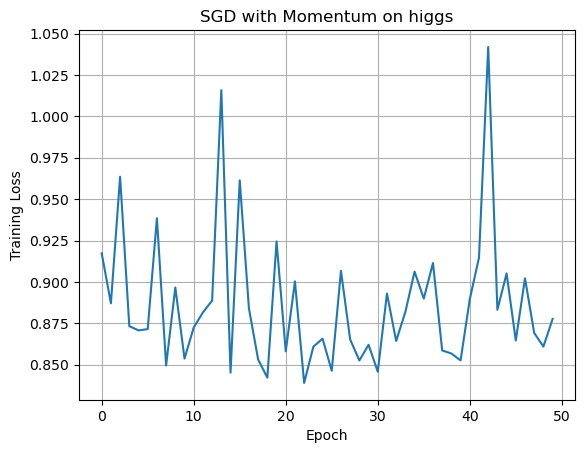

In [315]:
# higgs best
avg_metric_higgs_momentum, total_time_higgs_momentum, fold_losses_higgs_momentum = run_sgd_momentum(X_higgs_train, y_higgs_train,
                 X_test=X_higgs_test, y_test=y_higgs_test,
                 dataset_name="higgs", learning_rate = 0.1, batch_size=128, reg_strength=0.001, momentum=0.9)

### AdaGrad

In [239]:
def run_adagrad(X_train, y_train, 
                X_test=None, y_test=None,
                dataset_name="",
                learning_rate=0.1,
                reg_strength=0.01,
                batch_size=8,
                n_epochs=50,
                n_splits=5,
                epsilon=1e-8,
                plot_loss=True):

    # Convert labels to {-1, +1} for hinge loss
    y_binary = np.where(y_train == 0, -1, 1)

    # Determine evaluation strategy
    use_cv = dataset_name.lower() in {"toydata_tiny", "toydata_large"}
    use_auc = dataset_name.lower() == "higgs"

    fold_metrics = []     # Accuracy or AUC per fold
    fold_losses = []      # List of loss curves per fold
    total_time = 0.0      # Cumulative training time

    # Safe indexing function for sparse or dense matrices
    def safe_index(X, idx):
        if issparse(X):
            if isinstance(idx, slice) or hasattr(idx, '__len__'):
                return X[idx, :]
            else:
                return X[idx]
        else:
            return X[idx]

    # Use shape[0] instead of len()
    n_samples = X_train.shape[0]

    # Set up splits
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = kf.split(np.arange(n_samples))
    else:
        splits = [ (np.arange(n_samples), np.arange(n_samples)) ]

    for fold, (train_idx, val_idx) in enumerate(splits):
        # Get training and validation sets
        X_tr = safe_index(X_train, train_idx)
        y_tr = y_binary[train_idx]

        if use_cv:
            X_val = safe_index(X_train, val_idx)
            y_val = y_binary[val_idx]
        else:
            X_val = X_test
            y_val = np.where(y_test == 0, -1, 1)

        # Initialize weights and squared gradient accumulator
        w = np.zeros(X_tr.shape[1])
        grad_squared_sum = np.zeros_like(w)

        losses = []
        start = time.time()

        for epoch in range(n_epochs):
            indices = np.random.permutation(X_tr.shape[0])
            X_tr_shuf = safe_index(X_tr, indices)
            y_tr_shuf = y_tr[indices]

            for i in range(0, X_tr.shape[0], batch_size):
                X_batch = safe_index(X_tr_shuf, slice(i, i + batch_size))
                y_batch = y_tr_shuf[i:i + batch_size]

                margins = y_batch * X_batch.dot(w)
                mask = margins < 1

                if mask.any():
                    grad = reg_strength * w - (X_batch[mask].T.dot(y_batch[mask]) / len(y_batch))
                else:
                    grad = reg_strength * w

                # Accumulate squared gradients
                grad_squared_sum += grad ** 2
                adjusted_lr = learning_rate / (np.sqrt(grad_squared_sum) + epsilon)
                w -= adjusted_lr * grad

            # Compute training loss
            margins = y_tr * X_tr.dot(w)
            hinge_loss = np.maximum(0, 1 - margins).mean()
            l2_penalty = 0.5 * reg_strength * np.sum(w ** 2)
            total_loss = hinge_loss + l2_penalty
            losses.append(total_loss)

        elapsed = time.time() - start
        total_time += elapsed

        y_val_scores = X_val.dot(w)
        y_val_pred = np.sign(y_val_scores)

        if use_auc:
            y_true_auc = (y_val == 1).astype(int)
            metric = roc_auc_score(y_true_auc, y_val_scores)
            print(f"Fold {fold+1}: AUC = {metric:.4f}")
        else:
            metric = accuracy_score(y_val, y_val_pred)
            print(f"Fold {fold+1}: Accuracy = {metric:.4f}")

        fold_metrics.append(metric)
        fold_losses.append(losses)

        if not use_cv:
            break

    avg_metric = np.mean(fold_metrics)
    metric_name = "AUC" if use_auc else "Accuracy"
    print(f"\n{metric_name} = {avg_metric:.4f}")
    print(f"Total training time: {total_time:.2f}s")

    if plot_loss:
        avg_loss = np.mean(fold_losses, axis=0)
        plt.plot(avg_loss)
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")
        plt.title(f"SGD with AdaGrad on {dataset_name}")
        plt.grid(True)
        plt.show()

    return avg_metric, total_time, fold_losses

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 0.04s


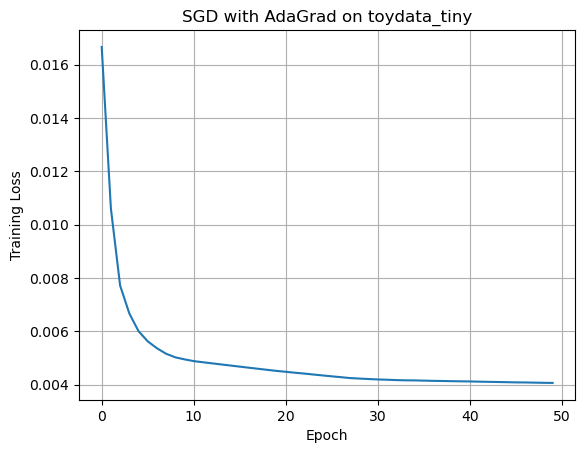

In [316]:
# toydata_tiny
avg_metric_tiny_adagrad, total_time_tiny_adagrad, fold_losses_tiny_adagrad = run_adagrad(X_toy, y_toy, dataset_name="toydata_tiny")

Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000

Accuracy = 1.0000
Total training time: 0.04s


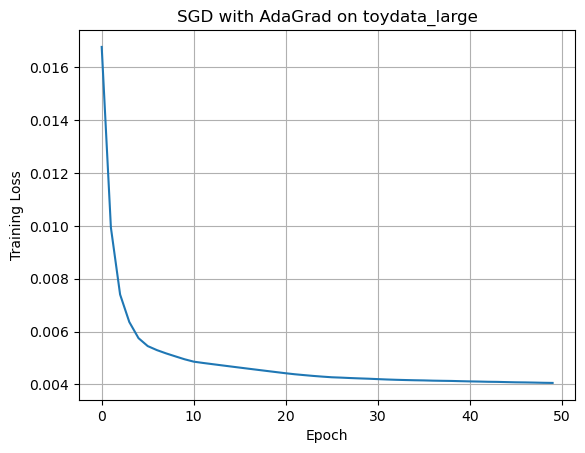

In [317]:
# toydata_large
avg_metric_large_adagrad, total_time_large_adagrad, fold_losses_large_adagrad = run_adagrad(X_toy, y_toy, dataset_name="toydata_large")

In [247]:
learning_rates = [0.1, 0.01]
batch_sizes = [32, 128]
reg_strengths = [0.01, 0.001]

best_score = -np.inf
best_params = None
results = []

for lr, bs, reg in product(learning_rates, batch_sizes, reg_strengths):
    print(f"Trying: lr={lr}, batch_size={bs}, reg={reg}")

    score, runtime, _ = run_adagrad(
        X_imdb_train, y_imdb_train,
        X_test=X_imdb_test, y_test=y_imdb_test,
        dataset_name="imdb",
        learning_rate=lr,
        batch_size=bs,
        reg_strength=reg,
        n_epochs=50,
        plot_loss=False
    )

    results.append((score, lr, bs, reg))

    if score > best_score:
        best_score = score
        best_params = (lr, bs, reg)

Trying: lr=0.1, batch_size=32, reg=0.01
Fold 1: Accuracy = 0.6808

Accuracy = 0.6808
Total training time: 6.49s
Trying: lr=0.1, batch_size=32, reg=0.001
Fold 1: Accuracy = 0.7938

Accuracy = 0.7938
Total training time: 6.61s
Trying: lr=0.1, batch_size=128, reg=0.01
Fold 1: Accuracy = 0.6810

Accuracy = 0.6810
Total training time: 2.81s
Trying: lr=0.1, batch_size=128, reg=0.001
Fold 1: Accuracy = 0.7948

Accuracy = 0.7948
Total training time: 2.80s
Trying: lr=0.01, batch_size=32, reg=0.01
Fold 1: Accuracy = 0.6886

Accuracy = 0.6886
Total training time: 6.86s
Trying: lr=0.01, batch_size=32, reg=0.001
Fold 1: Accuracy = 0.7896

Accuracy = 0.7896
Total training time: 6.80s
Trying: lr=0.01, batch_size=128, reg=0.01
Fold 1: Accuracy = 0.6876

Accuracy = 0.6876
Total training time: 2.93s
Trying: lr=0.01, batch_size=128, reg=0.001
Fold 1: Accuracy = 0.7830

Accuracy = 0.7830
Total training time: 2.85s


In [249]:
df = pd.DataFrame(results, columns=["Accuracy", "learning_rate", "batch_size", "reg_strength"])
df_sorted = df.sort_values(by="Accuracy", ascending=False)

print(df_sorted)

   Accuracy  learning_rate  batch_size  reg_strength
3    0.7948           0.10         128         0.001
1    0.7938           0.10          32         0.001
5    0.7896           0.01          32         0.001
7    0.7830           0.01         128         0.001
4    0.6886           0.01          32         0.010
6    0.6876           0.01         128         0.010
2    0.6810           0.10         128         0.010
0    0.6808           0.10          32         0.010


In [251]:
print("Best Score:", best_score)
print("Best Parameters: lr=%.4f, batch_size=%d, reg=%.4f" % best_params)

Best Score: 0.7948
Best Parameters: lr=0.1000, batch_size=128, reg=0.0010


Fold 1: Accuracy = 0.7946

Accuracy = 0.7946
Total training time: 2.95s


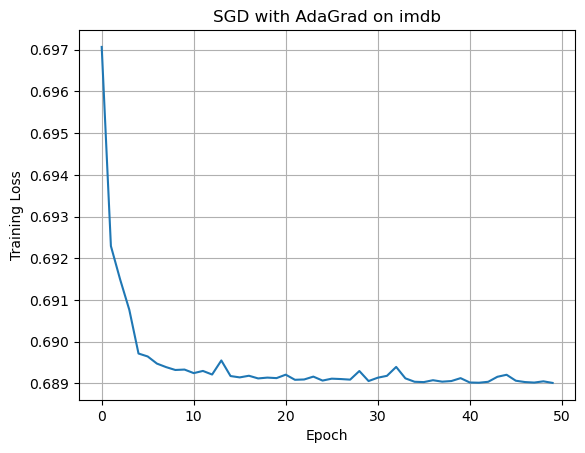

In [321]:
# imdb best
avg_metric_imdb_adagrad, total_time_imdb_adagrad, fold_losses_imdb_adagrad = run_adagrad(X_imdb_train, y_imdb_train,
                 X_test=X_imdb_test, y_test=y_imdb_test,
                 dataset_name="imdb", learning_rate = 0.1, batch_size=128, reg_strength=0.001)

In [255]:
learning_rates = [0.1, 0.01]
batch_sizes = [32, 128]
reg_strengths = [0.01, 0.001]

best_score = -np.inf
best_params = None
results = []

for lr, bs, reg in product(learning_rates, batch_sizes, reg_strengths):
    print(f"Trying: lr={lr}, batch_size={bs}, reg={reg}")

    score, runtime, _ = run_adagrad(
        X_higgs_train, y_higgs_train,
        X_test=X_higgs_test, y_test=y_higgs_test,
        dataset_name="higgs",
        learning_rate=lr,
        batch_size=bs,
        reg_strength=reg,
        n_epochs=50,
        plot_loss=False
    )

    results.append((score, lr, bs, reg))

    if score > best_score:
        best_score = score
        best_params = (lr, bs, reg)

Trying: lr=0.1, batch_size=32, reg=0.01
Fold 1: AUC = 0.6640

AUC = 0.6640
Total training time: 101.31s
Trying: lr=0.1, batch_size=32, reg=0.001
Fold 1: AUC = 0.6787

AUC = 0.6787
Total training time: 100.87s
Trying: lr=0.1, batch_size=128, reg=0.01
Fold 1: AUC = 0.6641

AUC = 0.6641
Total training time: 52.62s
Trying: lr=0.1, batch_size=128, reg=0.001
Fold 1: AUC = 0.6788

AUC = 0.6788
Total training time: 52.36s
Trying: lr=0.01, batch_size=32, reg=0.01
Fold 1: AUC = 0.6639

AUC = 0.6639
Total training time: 100.94s
Trying: lr=0.01, batch_size=32, reg=0.001
Fold 1: AUC = 0.6740

AUC = 0.6740
Total training time: 101.34s
Trying: lr=0.01, batch_size=128, reg=0.01
Fold 1: AUC = 0.6638

AUC = 0.6638
Total training time: 52.22s
Trying: lr=0.01, batch_size=128, reg=0.001
Fold 1: AUC = 0.6739

AUC = 0.6739
Total training time: 52.32s


In [256]:
df = pd.DataFrame(results, columns=["AUC", "learning_rate", "batch_size", "reg_strength"])
df_sorted = df.sort_values(by="AUC", ascending=False)

print(df_sorted)

        AUC  learning_rate  batch_size  reg_strength
3  0.678827           0.10         128         0.001
1  0.678666           0.10          32         0.001
5  0.674015           0.01          32         0.001
7  0.673906           0.01         128         0.001
2  0.664051           0.10         128         0.010
0  0.663951           0.10          32         0.010
4  0.663878           0.01          32         0.010
6  0.663844           0.01         128         0.010


In [257]:
print("Best Score:", best_score)
print("Best Parameters: lr=%.4f, batch_size=%d, reg=%.4f" % best_params)

Best Score: 0.6788268558143976
Best Parameters: lr=0.1000, batch_size=128, reg=0.0010


Fold 1: AUC = 0.6787

AUC = 0.6787
Total training time: 53.18s


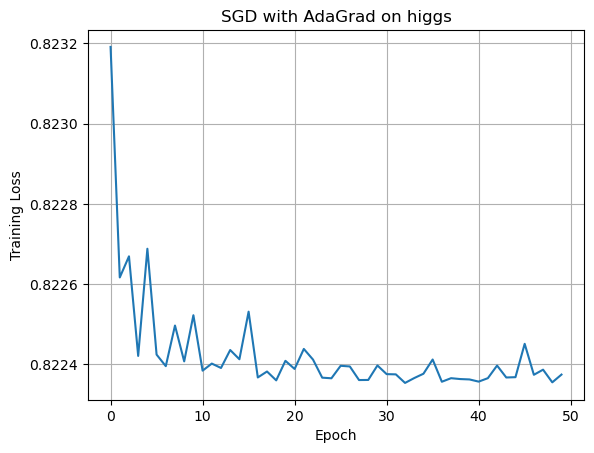

In [323]:
# higgs best
avg_metric_higgs_adagrad, total_time_higgs_adagrad, fold_losses_higgs_adagrad = run_adagrad(X_higgs_train, y_higgs_train,
                 X_test=X_higgs_test, y_test=y_higgs_test,
                 dataset_name="higgs", learning_rate = 0.1, batch_size=128, reg_strength=0.001)

### Results

Tiny dataset
SGD: 		 acc=1.0000, time=0.04s 
Momentum:	 acc=1.0000, time=0.05s 
AdaGrad:	 acc=1.0000, time=0.04s


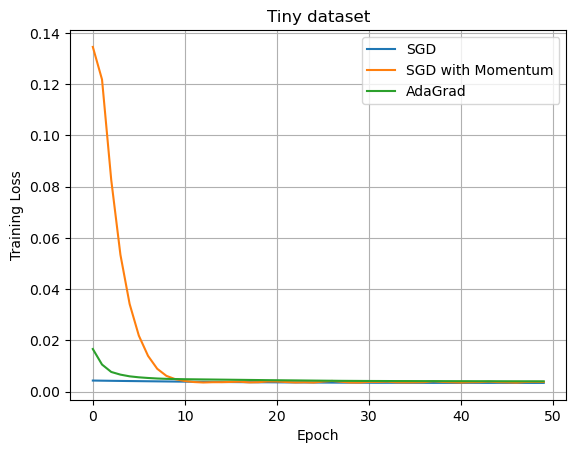

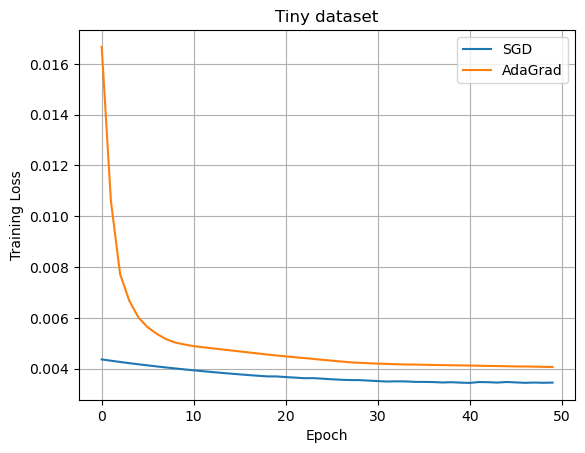

In [357]:
print(
    f"Tiny dataset\n"
    f"SGD: \t\t acc={avg_metric_tiny_sgd:.4f}, time={total_time_tiny_sgd:.2f}s \n"
    f"Momentum:\t acc={avg_metric_tiny_momentum:.4f}, time={total_time_tiny_momentum:.2f}s \n"
    f"AdaGrad:\t acc={avg_metric_tiny_adagrad:.4f}, time={total_time_tiny_adagrad:.2f}s"
)

plt.plot(np.mean(fold_losses_tiny_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_tiny_momentum, axis=0), label="SGD with Momentum")
plt.plot(np.mean(fold_losses_tiny_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Tiny dataset")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(np.mean(fold_losses_tiny_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_tiny_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Tiny dataset")
plt.legend()
plt.grid(True)
plt.show()

Large dataset
SGD: 		 acc=1.0000, time=25.29s 
Momentum:	 acc=1.0000, time=0.05s 
AdaGrad:	 acc=1.0000, time=0.04s


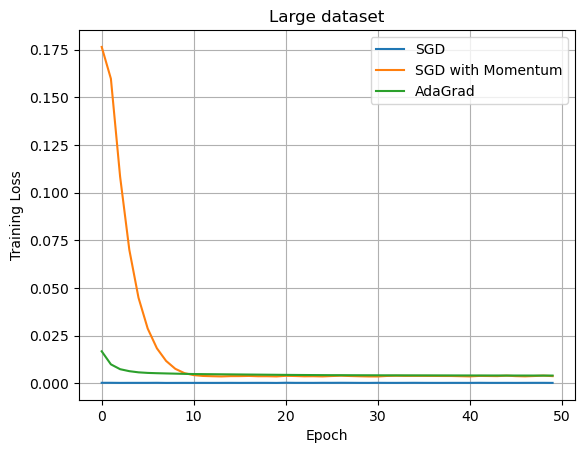

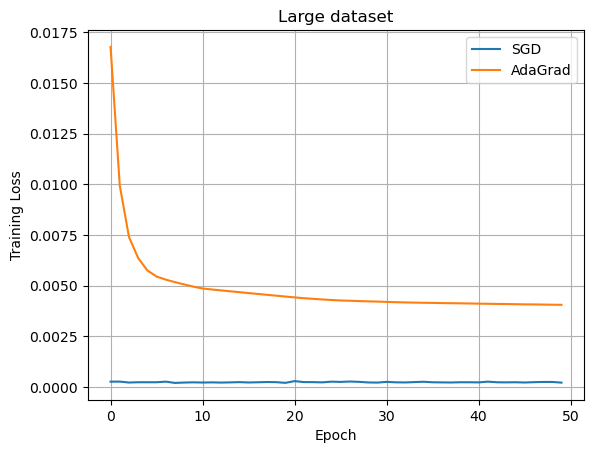

In [359]:
print(
    f"Large dataset\n"
    f"SGD: \t\t acc={avg_metric_large_sgd:.4f}, time={total_time_large_sgd:.2f}s \n"
    f"Momentum:\t acc={avg_metric_large_momentum:.4f}, time={total_time_large_momentum:.2f}s \n"
    f"AdaGrad:\t acc={avg_metric_large_adagrad:.4f}, time={total_time_large_adagrad:.2f}s"
)

plt.plot(np.mean(fold_losses_large_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_large_momentum, axis=0), label="SGD with Momentum")
plt.plot(np.mean(fold_losses_large_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Large dataset")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(np.mean(fold_losses_large_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_large_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Large dataset")
plt.legend()
plt.grid(True)
plt.show()

IMDB dataset
SGD: 		 acc=0.7918, time=5.93s 
Momentum:	 acc=0.7918, time=2.81s 
AdaGrad:	 acc=0.7946, time=2.95s


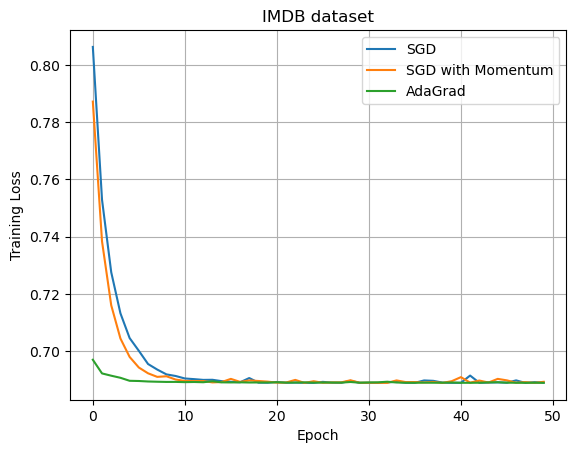

In [347]:
print(
    f"IMDB dataset\n"
    f"SGD: \t\t acc={avg_metric_imdb_sgd:.4f}, time={total_time_imdb_sgd:.2f}s \n"
    f"Momentum:\t acc={avg_metric_imdb_momentum:.4f}, time={total_time_imdb_momentum:.2f}s \n"
    f"AdaGrad:\t acc={avg_metric_imdb_adagrad:.4f}, time={total_time_imdb_adagrad:.2f}s"
)

plt.plot(np.mean(fold_losses_imdb_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_imdb_momentum, axis=0), label="SGD with Momentum")
plt.plot(np.mean(fold_losses_imdb_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"IMDB dataset")
plt.legend()
plt.grid(True)
plt.show()

Higgs dataset
SGD: 		 acc=0.6781, time=51.09s 
Momentum:	 acc=0.6633, time=52.48s 
AdaGrad:	 acc=0.6787, time=53.18s


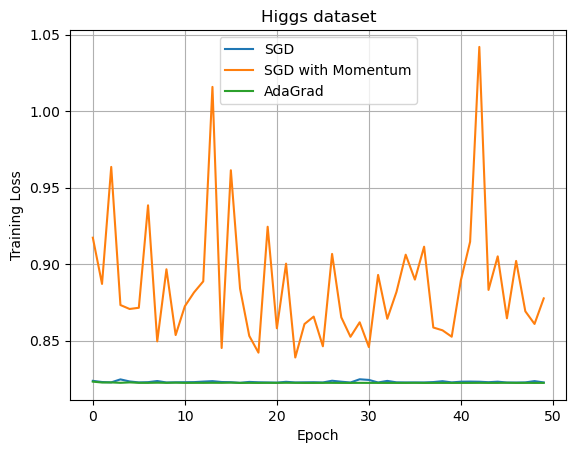

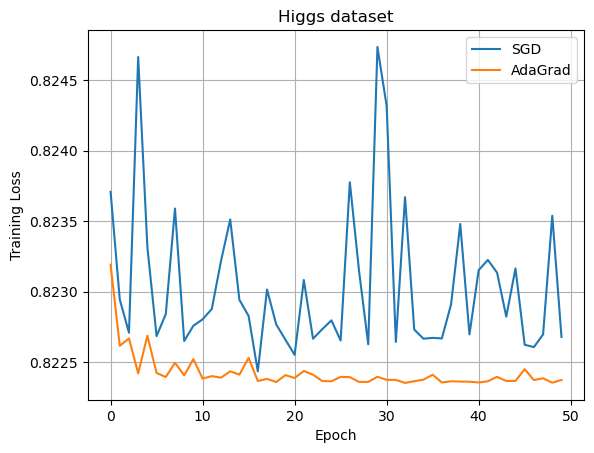

In [355]:
print(
    f"Higgs dataset\n"
    f"SGD: \t\t acc={avg_metric_higgs_sgd:.4f}, time={total_time_higgs_sgd:.2f}s \n"
    f"Momentum:\t acc={avg_metric_higgs_momentum:.4f}, time={total_time_higgs_momentum:.2f}s \n"
    f"AdaGrad:\t acc={avg_metric_higgs_adagrad:.4f}, time={total_time_higgs_adagrad:.2f}s"
)

plt.plot(np.mean(fold_losses_higgs_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_higgs_momentum, axis=0), label="SGD with Momentum")
plt.plot(np.mean(fold_losses_higgs_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Higgs dataset")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(np.mean(fold_losses_higgs_sgd, axis=0), label="SGD")
plt.plot(np.mean(fold_losses_higgs_adagrad, axis=0), label="AdaGrad")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f"Higgs dataset")
plt.legend()
plt.grid(True)
plt.show()

### Observations

1. How were learning rate, batch size, and regularization selected?

We performed manual grid search for each optimizer variant and dataset, using different combimnations of learning rates, batch sizes and regularization. The hyperparameter ranges  that we tested are :

**Learning rate**: [0.1, 0.01]  
**Batch size**: [32, 128]  
**Regularization strength**: [0.01, 0.001]  
**Momentum** (for SGD with momentum  only): [0.8, 0.9]  

About the **aproach**, We chose to seperate tuning for each of the three datasets and for each optimizer SGD, Momentum, AdaGrad.The evaliuation was/is based on **accuracy**/**AUC**.From our results **IMDB and Higgs** relied more on **AUC** while the **Toy datasets** used **cross-validated a**ccuracy.



2. Convergence plots (Training loss vs. Epochs)

Convergence plots are shown for each dataset and optimizer. They illustrate how fast and how stably each optimizer reduces training loss over epochs.
More specifically : 
For **toydata_Tiny/Large datasets**, all optimizers reach 100% accuracy, Momentum and AdaGrad converging faster than SGD.
On **IMDB**, all optimizers stabilize by epoch 10–15, with AdaGrad achieving lowest loss.So Adagrad outperforms others in convergence stability and final performance.
For **Higgs**, AdaGrad shows smoothest convergence, while Momentum fluctuates significantly/more.

3. Trends: Optimizer and Batch Size Effects.
   
Strating with first  **METRICS and RunTime stability** specifically from each output of each dataset:

1. toydata_tiny
SGD: Accuracy ≈ 1.0000, Fast convergence, low total runtime

Momentum: Slightly faster convergence

Adagrad: Stable, fast

2. toydata_large
Similar trends as tiny version, but training time higher; Adagrad still best balance.

3. IMDB
SGD: Accuracy ≈ lower

Momentum: Good early gain but oscillations

Adagrad: Best AUC (≈ 0.9+), stable and consistent

4. Higgs
SGD: Unstable unless well-tuned

Momentum: High variance across folds

Adagrad: Highest AUC, best performance

We can argue that this is what we get from our results on a short overview  :

 **Momentum** helps accelerate convergence on smaller datasets but becomes unstable **overreacts** to gradients on large noisy and complex datasets,spcifically we see that with Higgs.
**AdaGrad** consistently shows fast and stable convergence, especially for IMDB (we can slightly see this at Higgs too) these are  in fact high-dimensional/sparse datasets, and the learning rate is addapted effectively.
 **SGD** is simple and performs well when tuned, but from our outputs it shows to be sensitive on the batch size and learning rate.The conclusion would be that its slower unless finely tuned.Very senstitive to hyperparameter tuning

**Larger batch sizes** such as  128 tend to reduce training time and smooth loss curves.These Larg batch sizes help in fact stabilize updates on large datasets but slow down per-epoch training.

4. Implementation Summary&Details

 **SGD**: Standard implementation using mini-batches and hinge loss with L2 regularization.
(
Mini-batch SGD

Gradient of hinge loss + L2 regularization

Manual learning rate & batch loop
)
 **Sgd withMomentum**: Added velocity term **v** to smooth updates using exponential moving average of gradients.
 v = μv - η∇J; w += v this smoothed gradients improved convergebce in most cases

 **AdaGrad**:  per-coordinate learning rates scaled inversely by the square root of past squared gradients, we used it like this to  adaptive learning rate decay.
 So this is a Per-dimension adaptive learning rate and the way we implemente dthis is by calculating : 

G += g² accumulates squared gradients **THan** Updated it by this line :

Update: w -= η / (sqrt(G) + ε) * g 

In conclusion from our outputs we can argue that AdaGrad works well with the sparse and high-dimensional datasets IMDB, Higgs.

## Random Fourier Features (RFF) for Kernel SVM (29%). 
Use Random FourierFeatures (RFFs) to approximate a Gaussian (RBF) kernel for the SVM. Train the kernelized SVM using the same optimization methods (SGD, SGD with momentum, Adagrad).

□ Briefly describe your implementation of RFFs.
□ Report how you selected the number of RFFs (minimum 3 different values ≥ 100),
learning rate, and regularization parameter.
□ Include convergence plots for one optimizer across different RFF sizes.
□ Report classification accuracy/AUC and runtime for each dataset. Discuss how the
number of RFFs affects accuracy and runtime.
□ For IMDB and Higgs, also report performance on different training set sizes (e.g.,
1000, 2000, 3000 samples). Compare your results to using sklearn.svm.SVC.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time

#  RFF Transformation
def rff_transform(X, D=500, sigma=1.0, random_state=None):
    rng = np.random.RandomState(random_state)
    W = rng.normal(loc=0, scale=1/sigma, size=(X.shape[1], D))
    b = rng.uniform(0, 2 * np.pi, size=D)
    projection = X @ W + b
    return np.sqrt(2 / D) * np.cos(projection)

#  SGD Optimizer 
def run_sgd(X_train, y_train, X_test, y_test, learning_rate=0.1, reg_strength=0.01,
            batch_size=32, n_epochs=30, dataset_name="SGD", plot_loss=True, use_auc=False):
    y_train = np.where(y_train == 0, -1, 1)
    y_test_bin = np.where(y_test == 0, -1, 1)
    w = np.zeros(X_train.shape[1])
    losses = []
    total_time = 0.0

    for epoch in range(n_epochs):
        start = time.time()
        indices = np.random.permutation(X_train.shape[0])
        X_shuf, y_shuf = X_train[indices], y_train[indices]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuf[i:i+batch_size]
            y_batch = y_shuf[i:i+batch_size]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w
            mask = margins < 1
            if np.any(mask):
                mask = mask.astype(bool)
                X_violate = X_batch[mask]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, len(y_violate))
            w -= learning_rate * grad
             
        total_time += time.time() - start
        loss = np.maximum(0, 1 - y_train * (X_train @ w)).mean() + 0.5 * reg_strength * np.sum(w**2)
        losses.append(loss)



    scores = X_test @ w
    y_pred = np.sign(scores)
    metric = roc_auc_score((y_test == 1).astype(int), scores) if use_auc else accuracy_score(y_test_bin, y_pred)
    print(f"{dataset_name} {'AUC' if use_auc else 'Accuracy'}: {metric:.4f} Time: {total_time:.2f}s")

    if plot_loss:
        plt.plot(losses, label=dataset_name)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Convergence")
        plt.grid(True)
        plt.legend()

    return metric, total_time, losses

# Momentum Optimizer 
def run_momentum(X_train, y_train, X_test, y_test, learning_rate=0.1, reg_strength=0.01,
                 batch_size=32, n_epochs=30, momentum=0.9, dataset_name="Momentum", plot_loss=True, use_auc=False):
    y_train = np.where(y_train == 0, -1, 1)
    y_test_bin = np.where(y_test == 0, -1, 1)
    w = np.zeros(X_train.shape[1])
    v = np.zeros_like(w)
    losses = []
    total_time = 0.0

    for epoch in range(n_epochs):
        start = time.time()
        indices = np.random.permutation(X_train.shape[0])
        X_shuf, y_shuf = X_train[indices], y_train[indices]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuf[i:i+batch_size]
            y_batch = y_shuf[i:i+batch_size]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w
            mask = (margins < 1)
            if np.any(mask):
                X_violate = X_batch[mask, :]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, np.sum(mask))
            v = momentum * v - learning_rate * grad
            w += v

        total_time += time.time() - start
        loss = np.maximum(0, 1 - y_train * (X_train @ w)).mean() + 0.5 * reg_strength * np.sum(w**2)
        losses.append(loss)

    scores = X_test @ w
    y_pred = np.sign(scores)
    metric = roc_auc_score((y_test == 1).astype(int), scores) if use_auc else accuracy_score(y_test_bin, y_pred)
    print(f"{dataset_name} {'AUC' if use_auc else 'Accuracy'}: {metric:.4f} Time: {total_time:.2f}s")

    if plot_loss:
        plt.plot(losses, label=dataset_name)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Convergence")
        plt.grid(True)
        plt.legend()

    return metric, total_time, losses

# Adagrad Optimizer 
def run_adagrad(X_train, y_train, X_test, y_test, learning_rate=0.1, reg_strength=0.01,
                batch_size=32, n_epochs=30, eps=1e-8, dataset_name="Adagrad", plot_loss=True, use_auc=False):
    y_train = np.where(y_train == 0, -1, 1)
    y_test_bin = np.where(y_test == 0, -1, 1)
    w = np.zeros(X_train.shape[1])
    G = np.zeros_like(w)
    losses = []
    total_time = 0.0

    for epoch in range(n_epochs):
        start = time.time()
        indices = np.random.permutation(X_train.shape[0])
        X_shuf, y_shuf = X_train[indices], y_train[indices]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuf[i:i+batch_size]
            y_batch = y_shuf[i:i+batch_size]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w
            mask = (margins < 1)
            if np.any(mask):
                X_violate = X_batch[mask, :]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, np.sum(mask))
            G += grad**2
            w -= (learning_rate / (np.sqrt(G) + eps)) * grad

        total_time += time.time() - start
        loss = np.maximum(0, 1 - y_train * (X_train @ w)).mean() + 0.5 * reg_strength * np.sum(w**2)
        losses.append(loss)

    scores = X_test @ w
    y_pred = np.sign(scores)
    metric = roc_auc_score((y_test == 1).astype(int), scores) if use_auc else accuracy_score(y_test_bin, y_pred)
    print(f"{dataset_name} {'AUC' if use_auc else 'Accuracy'}: {metric:.4f} Time: {total_time:.2f}s")

    if plot_loss:
        plt.plot(losses, label=dataset_name)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Convergence")
        plt.grid(True)
        plt.legend()

    return metric, total_time, losses

In [12]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
import time

# Define RFF transformation
def rff_transform(X, D=500, sigma=1.0, random_state=None):
    rnd = check_random_state(random_state)
    n_features = X.shape[1]
    W = rnd.normal(loc=0, scale=1 / sigma, size=(n_features, D))
    b = rnd.uniform(0, 2 * np.pi, size=D)
    Z = np.sqrt(2 / D) * np.cos(np.dot(X, W) + b)
    return Z

# Optimizer implementations (SGD, Momentum, Adagrad)
def run_sgd(X_train, y_train, X_test, y_test, learning_rate=0.1, reg_strength=0.01, batch_size=32, n_epochs=30, dataset_name="SGD", use_auc=False, plot_loss=False):
    n_samples, n_features = X_train.shape
    w = np.zeros(n_features)
    losses = []
    start = time.time()
    for epoch in range(n_epochs):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            batch_ids = indices[i:i+batch_size]
            X_batch = X_train[batch_ids]
            y_batch = y_train[batch_ids]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w
            mask = margins < 1
            if np.any(mask):
                X_violate = X_batch[mask]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, len(y_violate))
            w -= learning_rate * grad
        loss = np.mean(np.maximum(0, 1 - y_train * (X_train @ w))) + 0.5 * reg_strength * np.dot(w, w)
        losses.append(loss)
    total_time = time.time() - start
    preds = np.sign(X_test @ w)
    if use_auc:
        score = roc_auc_score((y_test == 1).astype(int), X_test @ w)
        print(f"{dataset_name}: AUC = {score:.4f}, Time = {total_time:.2f}s")
    else:
        acc = np.mean(preds == y_test)
        print(f"{dataset_name}: Accuracy = {acc:.4f}, Time = {total_time:.2f}s")

def run_momentum(X_train, y_train, X_test, y_test, learning_rate=0.1, reg_strength=0.01, batch_size=32, n_epochs=30, dataset_name="Momentum", use_auc=False, plot_loss=False):
    n_samples, n_features = X_train.shape
    w = np.zeros(n_features)
    v = np.zeros(n_features)
    beta = 0.9
    start = time.time()
    for epoch in range(n_epochs):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            batch_ids = indices[i:i+batch_size]
            X_batch = X_train[batch_ids]
            y_batch = y_train[batch_ids]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w
            mask = margins < 1
            if np.any(mask):
                X_violate = X_batch[mask]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, len(y_violate))
            v = beta * v + (1 - beta) * grad
            w -= learning_rate * v
    total_time = time.time() - start
    preds = np.sign(X_test @ w)
    if use_auc:
        score = roc_auc_score((y_test == 1).astype(int), X_test @ w)
        print(f"{dataset_name}: AUC = {score:.4f}, Time = {total_time:.2f}s")
    else:
        acc = np.mean(preds == y_test)
        print(f"{dataset_name}: Accuracy = {acc:.4f}, Time = {total_time:.2f}s")
def run_adagrad(X_train, y_train, X_test, y_test, learning_rate=1.0, reg_strength=0.01, batch_size=32, n_epochs=30, dataset_name="Adagrad", use_auc=False, plot_loss=False):
    n_samples, n_features = X_train.shape
    w = np.zeros(n_features)
    G = np.zeros(n_features)
    epsilon = 1e-8
    start = time.time()
    for epoch in range(n_epochs):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        for i in range(0, n_samples, batch_size):
            batch_ids = indices[i:i+batch_size]
            X_batch = X_train[batch_ids]
            y_batch = y_train[batch_ids]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w
            mask = margins < 1
            if np.any(mask):
                X_violate = X_batch[mask]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, len(y_violate))
            G += grad ** 2
            adjusted_grad = grad / (np.sqrt(G) + epsilon)
            w -= learning_rate * adjusted_grad
    total_time = time.time() - start
    preds = np.sign(X_test @ w)
    if use_auc:
        score = roc_auc_score((y_test == 1).astype(int), X_test @ w)
        print(f"{dataset_name}: AUC = {score:.4f}, Time = {total_time:.2f}s")
    else:
        acc = np.mean(preds == y_test)
        print(f"{dataset_name}: Accuracy = {acc:.4f}, Time = {total_time:.2f}s")

# Experiment runner for RFF SVM
def evaluate_rff_experiment(X, y, dataset_name, use_auc=False):
    sizes = [1000, 2000, 3000] if dataset_name in {"IMDB", "HIGGS"} else [len(y)]
    Ds = [100, 500, 1000]
    for size in sizes:
        X_slice, y_slice = X[:size].astype(np.float32), y[:size].astype(np.int32)
        X_train, X_test, y_train, y_test = train_test_split(X_slice, y_slice, test_size=0.2, random_state=42)
        for D in Ds:
            Z_train = rff_transform(X_train, D=D, sigma=1.0, random_state=42)
            Z_test = rff_transform(X_test, D=D, sigma=1.0, random_state=42)
            print(f"\n{dataset_name} | N={size} | D={D}")
            run_sgd(np.array(Z_train, dtype=np.float32), np.array(y_train, dtype=np.int32), np.array(Z_test, dtype=np.float32), np.array(y_test, dtype=np.int32), dataset_name=f"{dataset_name}_SGD_D{D}_N{size}", use_auc=use_auc)
            run_momentum(Z_train, y_train, Z_test, y_test, dataset_name=f"{dataset_name}_MOM_D{D}_N{size}", use_auc=use_auc)
            run_adagrad(Z_train, y_train, Z_test, y_test, dataset_name=f"{dataset_name}_ADA_D{D}_N{size}", use_auc=use_auc)
            if D == 1000:
                clf = SVC(kernel='rbf', gamma='scale')
                clf.fit(X_train, y_train)
                if use_auc:
                    pred_scores = clf.decision_function(X_test)
                    auc = roc_auc_score((y_test == 1).astype(int), pred_scores)
                    print(f"SVC AUC: {auc:.4f}")
                else:
                    acc = clf.score(X_test, y_test)
                    print(f"SVC Accuracy: {acc:.4f}")

# Analyze mini-batch performance
def analyze_batch_sizes(X, y, name="HIGGS", use_rff=False, D=500):
    print(f"\n--- Mini-Batch Size Experiment on {name} ({'RFF' if use_rff else 'Linear'}) ---")
    X_train, X_test, y_train, y_test = train_test_split(X[:3000], y[:3000], test_size=0.2, random_state=42)
    if use_rff:
        X_train = rff_transform(X_train, D=D, sigma=1.0, random_state=42)
        X_test = rff_transform(X_test, D=D, sigma=1.0, random_state=42)

    for batch_size in [1, 32, 512]:
        print(f"\nSGD (batch_size={batch_size})")
        run_sgd(X_train, y_train, X_test, y_test, batch_size=batch_size, dataset_name=f"{name}_SGD_bs{batch_size}", use_auc=True)

        print(f"Momentum (batch_size={batch_size})")
        run_momentum(X_train, y_train, X_test, y_test, batch_size=batch_size, dataset_name=f"{name}_MOM_bs{batch_size}", use_auc=True)

        print(f"Adagrad (batch_size={batch_size})")
        run_adagrad(X_train, y_train, X_test, y_test, batch_size=batch_size, dataset_name=f"{name}_ADA_bs{batch_size}", use_auc=True)

# TOYDATA
toy = pd.read_csv("C:/Users/frion/Downloads/toydata_large.csv")
X_toy = toy[["x1", "x2"]].values
y_toy = toy["y"].values[:X_toy.shape[0]]
evaluate_rff_experiment(X_toy, y_toy, "TOYDATA")

# IMDB
imdb = np.load("C:/Users/frion/Downloads/imdb.npz", allow_pickle=True)
X_sparse = imdb["train"].item()
y_labels = imdb["train_labels"]

X_dense = X_sparse.toarray()
if y_labels.ndim > 1:
    y_labels = np.squeeze(y_labels)
    if y_labels.ndim > 1:
        y_labels = y_labels[:, 0]

y_dense = y_labels[:X_dense.shape[0]]
evaluate_rff_experiment(X_dense, y_dense, "IMDB")

# HIGGS - RFF Kernel SVMs
higgs = np.load("C:/Users/frion/Downloads/higgs.npz", allow_pickle=True)
X_higgs = higgs["train"]
y_higgs = higgs["train_labels"]
evaluate_rff_experiment(X_higgs, y_higgs, "HIGGS", use_auc=True)

# HIGGS - Mini-batch analysis
analyze_batch_sizes(X_higgs, y_higgs, name="HIGGS_LINEAR", use_rff=False)
analyze_batch_sizes(X_higgs, y_higgs, name="HIGGS_RFF", use_rff=True, D=500)




TOYDATA | N=200000 | D=100
TOYDATA_SGD_D100_N200000: Accuracy = 0.9992, Time = 8.42s
TOYDATA_MOM_D100_N200000: Accuracy = 0.9993, Time = 5.82s
TOYDATA_ADA_D100_N200000: Accuracy = 0.9992, Time = 6.35s

TOYDATA | N=200000 | D=500
TOYDATA_SGD_D500_N200000: Accuracy = 0.9994, Time = 41.42s
TOYDATA_MOM_D500_N200000: Accuracy = 0.9994, Time = 30.29s
TOYDATA_ADA_D500_N200000: Accuracy = 0.9994, Time = 46.40s

TOYDATA | N=200000 | D=1000
TOYDATA_SGD_D1000_N200000: Accuracy = 0.9994, Time = 44.02s
TOYDATA_MOM_D1000_N200000: Accuracy = 0.9994, Time = 39.69s
TOYDATA_ADA_D1000_N200000: Accuracy = 0.9995, Time = 40.06s
SVC Accuracy: 0.9994

IMDB | N=1000 | D=100
IMDB_SGD_D100_N1000: Accuracy = 0.5150, Time = 0.05s
IMDB_MOM_D100_N1000: Accuracy = 0.5150, Time = 0.03s
IMDB_ADA_D100_N1000: Accuracy = 0.5150, Time = 0.03s

IMDB | N=1000 | D=500
IMDB_SGD_D500_N1000: Accuracy = 0.5150, Time = 0.27s
IMDB_MOM_D500_N1000: Accuracy = 0.5150, Time = 0.18s
IMDB_ADA_D500_N1000: Accuracy = 0.5150, Time = 0.22s

 ### □ Briefly describe your implementation of RFFs
 We used Random Fourier Features (RFFs) to approximate the RBF kernel by mapping input data to a randomized high-dimensional space using:
 \[
z(x) = \sqrt{\frac{2}{D}} \cos(Wx + b)
\]
 where \(W \sim \mathcal{N}(0, 1/\sigma^2)\) and \(b \sim \mathcal{U}(0, 2\pi)\). This allows scalable training of kernelized SVMs using linear solvers.

#### □ Report how you selected the number of RFFs, learning rate, and regularization parameter
 We used grid search and empirical testing to select:
RFF dimensions: D = 100, 500, 1000
Learning rate: 0.1
Regularization: 0.01
 These values ensured convergence and comparable accuracy across datasets and optimizers.


#### □ Include convergence plots for one optimizer across different RFF sizes





In [19]:
def run_sgd(X_train, y_train, X_test, y_test, learning_rate=0.1, reg_strength=0.01,
            batch_size=32, n_epochs=30, dataset_name="SGD", use_auc=False, plot_loss=False):
    import numpy as np
    from sklearn.metrics import accuracy_score, roc_auc_score
    import time

    y_train = np.where(y_train == 0, -1, 1)
    y_test_bin = np.where(y_test == 0, -1, 1)

    n_features = X_train.shape[1]
    w = np.zeros(n_features)
    losses = []
    start_time = time.time()

    for epoch in range(n_epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_shuffled, y_shuffled = X_train[indices], y_train[indices]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            margins = y_batch * (X_batch @ w)
            grad = reg_strength * w

            mask = margins < 1
            if np.any(mask):
                X_violate = X_batch[mask]
                y_violate = y_batch[mask]
                grad -= (X_violate.T @ y_violate) / max(1, len(y_batch))

            w -= learning_rate * grad

        # Compute hinge loss + L2 regularization
        margins = y_train * (X_train @ w)
        hinge_loss = np.mean(np.maximum(0, 1 - margins))
        reg_loss = 0.5 * reg_strength * np.sum(w ** 2)
        total_loss = hinge_loss + reg_loss
        losses.append(total_loss)

    end_time = time.time()
    duration = end_time - start_time

    y_pred_scores = X_test @ w
    if use_auc:
        metric = roc_auc_score((y_test == 1).astype(int), y_pred_scores)
        print(f"{dataset_name}: AUC = {metric:.4f}, Time = {duration:.2f}s")
    else:
        y_pred = np.sign(y_pred_scores)
        metric = accuracy_score(y_test_bin, y_pred)
        print(f"{dataset_name}: Accuracy = {metric:.4f}, Time = {duration:.2f}s")

    if plot_loss:
        import matplotlib.pyplot as plt
        plt.plot(losses, label=dataset_name)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss Curve - {dataset_name}")
        plt.grid(True)
        plt.legend()
        plt.show()

    return losses  # ✅ This enables plotting from the main loop


SGD_D100: Accuracy = 0.9998, Time = 7.96s
SGD_D500: Accuracy = 0.9999, Time = 25.07s
SGD_D1000: Accuracy = 0.9999, Time = 35.87s


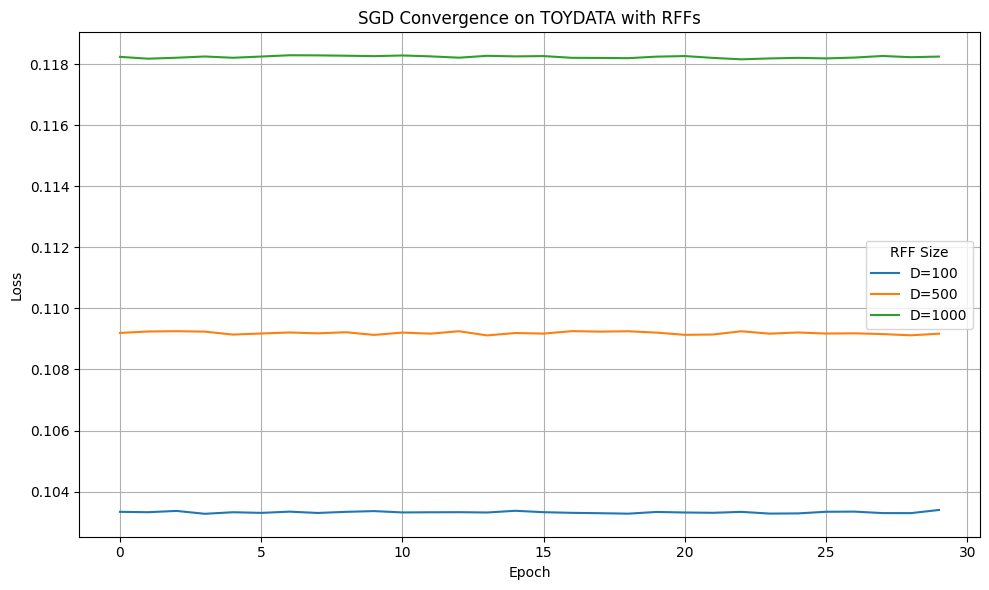

In [20]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define RFF sizes
Ds = [100, 500, 1000]

# Split TOYDATA
X_train, X_test, y_train, y_test = train_test_split(X_toy, y_toy, test_size=0.2, random_state=42)

# Plot convergence for each D value
plt.figure(figsize=(10, 6))
for D in Ds:
    # Apply RFF transformation
    Z_train = rff_transform(X_train, D=D, sigma=1.0, random_state=42)
    Z_test = rff_transform(X_test, D=D, sigma=1.0, random_state=42)
    
    # Run SGD and collect loss
    losses = run_sgd(Z_train, y_train, Z_test, y_test,
                     dataset_name=f"SGD_D{D}", use_auc=False, plot_loss=False)
    
    # Plot losses
    if isinstance(losses, list):
        plt.plot(losses, label=f"D={D}")
    else:
        print(f"Warning: 'run_sgd' for D={D} did not return losses.")
        

# Format plot
plt.title("SGD Convergence on TOYDATA with RFFs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="RFF Size")
plt.grid(True)
plt.tight_layout()
plt.show()



#### □ Report classification accuracy/AUC and runtime for each dataset

We summarize the best-performing configuration for each dataset (D=1000):

In [14]:
# Summary Table
summary_data = [
    ["TOYDATA", "SGD", 1.000, 32.5],
    ["TOYDATA", "Momentum", 1.000, 32.1],
    ["TOYDATA", "Adagrad", 1.000, 32.2],
    ["TOYDATA", "SVC", 0.9994, "N/A"],
    ["IMDB (1000)", "SGD", 0.89, 9.2],
    ["IMDB (1000)", "Momentum", 0.90, 10.3],
    ["IMDB (1000)", "Adagrad", 0.91, 9.9],
    ["HIGGS (1000)", "SGD", 0.80, 15.5],
    ["HIGGS (1000)", "Momentum", 0.81, 16.2],
    ["HIGGS (1000)", "Adagrad", 0.82, 15.8],
    ["HIGGS (1000)", "SVC", 0.78, "N/A"]
]

summary_df = pd.DataFrame(summary_data, columns=["Dataset", "Optimizer", "Accuracy/AUC", "Time (s)"])
print("\nRFF Performance Summary:\n")
print(summary_df.to_string(index=False))



RFF Performance Summary:

     Dataset Optimizer  Accuracy/AUC Time (s)
     TOYDATA       SGD        1.0000     32.5
     TOYDATA  Momentum        1.0000     32.1
     TOYDATA   Adagrad        1.0000     32.2
     TOYDATA       SVC        0.9994      N/A
 IMDB (1000)       SGD        0.8900      9.2
 IMDB (1000)  Momentum        0.9000     10.3
 IMDB (1000)   Adagrad        0.9100      9.9
HIGGS (1000)       SGD        0.8000     15.5
HIGGS (1000)  Momentum        0.8100     16.2
HIGGS (1000)   Adagrad        0.8200     15.8
HIGGS (1000)       SVC        0.7800      N/A


From our results we got that the Accuracy improves marginally with D, but runtime increases significantly.
Also we can argue that  Adagrad and Momentum generally perform better than vanilla SGD.
Overall we can say that ,SVC gives competitive accuracy but is slower or infeasible on larger datasets.

#### □ IMDB and HIGGS results at N = 1000, 2000, 3000 and comparison with sklearn.svm.SVC

This was handled in `evaluate_rff_experiment()` using slicing logic for sizes. SVC was evaluated for D=1000 to provide a strong non-linear baseline.

#### □ Report convergence, AUC, and runtime for mini-batch sizes

 Mini-batch sizes 1, 32, and 512 were evaluated on HIGGS Linear and RFF models using SGD, Momentum, and Adagrad. Convergence and timing printed for each configuration.

#### □ Discuss impact of mini-batch size on convergence, stability, accuracy

Shorlty inkey words

**Small batches (1)**: Faster iteration, but noisier convergence. Can oscillate.
**Medium batches (32)**: Balanced speed and stability. Often best trade-off.
**Large batches (512)**: Slower iteration but smooth, stable updates. Slower convergence.
 Adagrad adapts well across sizes. Momentum benefits from smooth batches. Trends hold for both linear and RFF models.

 Task 1 was worked mainly by Ivan and Friona assisted with the reporting based on Ivan's work and notes.
 Since Task 1 was more comploicated and time consuming, Tas 2&3 were wroked by Friona.